In [29]:
from imports import *
plt.rc('figure', max_open_warning=200)
%matplotlib inline
sns.set_theme()

# Loading  preprosessed data

In [30]:
# Initialize path variables for main folders

print(os.getcwd())

# Path for saving epoch data and features
ft_dir_path = os.path.join(os.getcwd(), 'features')
data_dir_path = os.path.join(os.getcwd(), 'word_data')


/Users/savochkin


In [31]:
raw = mne.io.read_raw_fif('reref_filterd_raw.fif', preload=True)


Opening raw data file reref_filterd_raw.fif...
    Range : 0 ... 1806049 =      0.000 ...  1806.049 secs
Ready.
Reading 0 ... 1806049  =      0.000 ...  1806.049 secs...


In [3]:
raw

<Raw | reref_filterd_raw.fif, 63 x 1806050 (1806.0 s), ~868.2 MB, data loaded>

# Epoching data

In [32]:
gc.collect()

4

## Global variables & filtering

In [33]:
# Frequency bands

bands = [(0.9, 4, 'Delta (0.9-4 Hz)', 'D'), (4, 8, 'Theta (4-8 Hz)', 'T'), (8, 14, 'Alpha (8-14 Hz)', 'A'), 
         (14, 25, 'Beta (14-25 Hz)', 'B'), (25, 45, 'Gamma (25-45 Hz)', 'G')]

str_freq_rr = [bands[i][3] for i in range(len(bands))] #bands names 'D', 'T', 'A', 'B', 'G'
n_freq = len(str_freq_rr) # 5

In [34]:
# Localization by scalp regions

regions = [(['Fp1','Fp2','Fpz'], 'Fp', 'Pre-frontal'),
           (['AF7, AF3','AF4','AF8'], 'AF', 'In-between frontal'),
           (['F9','F7','F5','F3','FT9','FT7','FC5','FC3'], 'LF', 'Left Frontal'),
           (['F1','Fz','F2','FC1','FCz','FC2'], 'MF', 'Midline Frontal'),
           (['F4','F6','F8','F10','FC4','FC6','FT8','FT10'], 'RF', 'Right Frontal'),
           (['T7','TP9','TP7'], 'LT', 'Left Temporal'),
           (['T8','TP8','TP10'], 'RT', 'Right Temporal'),
           (['C5','C3','CP5','CP3'], 'LC', 'Left Central'),
           (['C1','Cz','C2','CP1','CPz', 'CP2'], 'MC', 'Midline Central'),
           (['C4','C6','CP4','CP6'], 'RC', 'Right Central'),
           (['P9','P7','P5','P3'], 'LP', 'Left Parietal'),
           (['P1','Pz','P2'], 'MP', 'Midline Parietal'),
           (['P4','P6','P8','P10'], 'RP', 'Right Parietal'),
           (['PO9','PO7','PO3','O1'], 'LO', 'Left Occipital'),
           (['POz','Oz'], 'MO', 'Midline Occipital'),
           (['PO4','PO8','PO10','O2'], 'RO', 'Right Occipital')]


n_regions = len(regions)


## Epoching

In [35]:
gc.collect()

0

In [42]:
# Epochs by fixed length events, duration 5s, overlap 0.2s (re-referenced)

sec5_events = mne.make_fixed_length_events(raw, start=0.5, duration=5.)
kwargs = dict(baseline=None, tmin=-0.5, tmax=0.5, preload=True)
sec5_epochs = mne.Epochs(raw, sec5_events.astype(int), **kwargs)[2:-2]



Not setting metadata
361 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 361 events and 1001 original time points ...
0 bad epochs dropped


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


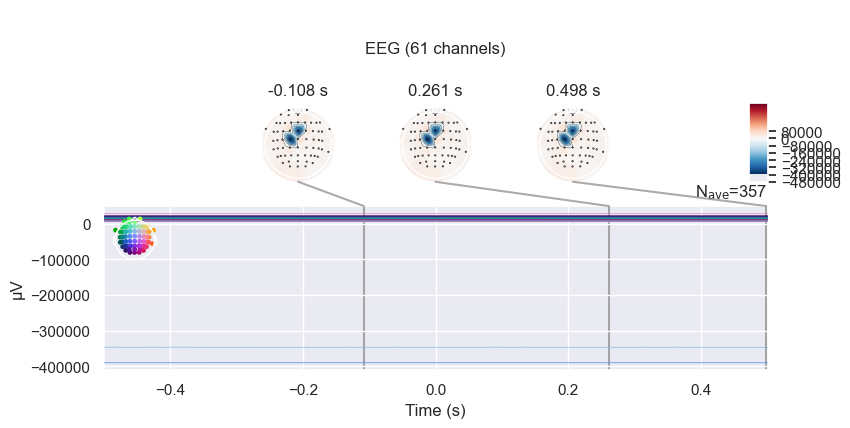

In [43]:
sec5_epochs.average().plot_joint()
print()

In [44]:
# Global variables

ch_names = sec5_epochs.ch_names
n_freq = len(str_freq_rr)
n_channels = len(ch_names)

n_samples = sec5_epochs.__len__()
n_times = len(sec5_epochs.get_data()[0,0,:])

sampling_rate = raw.info['sfreq']

# Extract features

## PSD features

In [45]:
# Calculating PSD for re-referenced epochs (Multitaper)

kwargs = dict(fmin=bands[0][0], fmax=bands[-1][1], sfreq=sampling_rate, bandwidth=None, adaptive=True, n_jobs=1)
rr_psd_mtaper, rr_freq_mtaper = psd_array_multitaper(sec5_epochs.get_data(), **kwargs)



    Using multitaper spectrum estimation with 7 DPSS windows


In [ ]:
# print(rr_freq_mtaper) # 0.9 - 40
# print(rr_psd_mtaper.shape) # (2497, 70, 40)

In [14]:
freq_masks = [(fmin < rr_freq_mtaper) & (rr_freq_mtaper < fmax) for (fmin, fmax, _, _) in bands]
loc_masks = [[ch_names[i] in reg for i in range(n_channels)] for (reg, _, _) in regions] # 16 x 70
# loc_plt_masks = [[ch_names[i] in reg for i in range(n_channels)] for (reg, _, _) in regions_plt] # 9 x 70


In [15]:
# for each frequency band (2497, 70, 5)
ft_psd_spectr_raw = np.array([np.mean(rr_psd_mtaper[:,:, _freq_mask], axis=2) for _freq_mask in freq_masks]).transpose(1,2,0)
# for each freq. band + for region (2497, 16, 5)
ft_psd_sp_loc_raw = np.array([np.mean(ft_psd_spectr_raw[:,_mask,:], axis=1) for _mask in loc_masks]).transpose(1,0,2)
# average among channels by epoch for each band (2497, 5)
ft_psd_sp_all_raw = np.mean(ft_psd_spectr_raw, axis=1)


In [16]:
ft_psd_spectr_db = 10 * np.log10(ft_psd_spectr_raw) # Convert psd to dB format
ft_psd_sp_loc_db = 10 * np.log10(ft_psd_sp_loc_raw) # Convert psd to dB 
ft_psd_sp_all_db = 10 * np.log10(ft_psd_sp_all_raw) # Convert psd to dB format

In [17]:

df_ft_psd_raw = pd.DataFrame()
df_ft_psd_db = pd.DataFrame()

df_ft_psd_loc_raw = pd.DataFrame()
df_ft_psd_loc_db = pd.DataFrame()

df_ft_psd_all_raw = pd.DataFrame()
df_ft_psd_all_db = pd.DataFrame()

In [18]:
for i in range(n_freq): # 5
    for j in range(n_channels): # 70
        df_ft_psd_raw[str_freq_rr[i]+'_psd_'+ch_names[j]] = ft_psd_spectr_raw[:,j,i]
        df_ft_psd_db[str_freq_rr[i]+'_psd_'+ch_names[j]] = ft_psd_spectr_db[:,j,i]
    for j in range(n_regions):    
        df_ft_psd_loc_raw[str_freq_rr[i]+'_psd_'+regions[j][1]] = ft_psd_sp_loc_raw[:,j,i]
        df_ft_psd_loc_db[str_freq_rr[i]+'_psd_'+regions[j][1]] = ft_psd_sp_loc_db[:,j,i]
    df_ft_psd_all_raw[str_freq_rr[i]+'_psd_All'] = ft_psd_sp_all_raw[:,i]
    df_ft_psd_all_db[str_freq_rr[i]+'_psd_All'] = ft_psd_sp_all_db[:,i]



In [19]:
# Scaling dB re-referenced data
ft_psd_db_sc = StandardScaler().fit_transform(df_ft_psd_db.to_numpy())
df_ft_psd_db_sc = pd.DataFrame(ft_psd_db_sc, columns=df_ft_psd_db.columns)

ft_psd_loc_db_sc = StandardScaler().fit_transform(df_ft_psd_loc_db.to_numpy())
df_ft_psd_loc_db_sc = pd.DataFrame(ft_psd_loc_db_sc, columns=df_ft_psd_loc_db.columns)

ft_psd_all_db_sc = StandardScaler().fit_transform(df_ft_psd_all_db.to_numpy())
df_ft_psd_all_db_sc = pd.DataFrame(ft_psd_all_db_sc, columns=df_ft_psd_all_db.columns)

## PSD Indices

In [20]:
df_ft_psd_ind = pd.DataFrame()

# theta/delta, alpha/delta, alpha/theta, alpha/(delta+theta), 
# beta/delta, beta/theta, beta/alpha, beta/(delta+theta), 
# beta/(theta+alpha), gamma/delta, gamma/theta, gamma/alpha, gamma/beta, 
# gamma/(delta+theta), gamma/(theta+alpha) and gamma /(alpha+beta)
str_psd_ind = ['T_D','A_D','A_T','A_DT','B_D','B_T','B_A','B_DT','B_TA','G_D','G_T','G_A','G_B','G_DT','G_TA','G_AB']

df_ft_psd_ind_loc = pd.DataFrame()
df_ft_psd_ind_all = pd.DataFrame()

# Indices per region (averaged PSD)
for _r in range(n_regions):
    for ind in str_psd_ind:
        if (len(ind)==3):
            df_ft_psd_ind_loc[ind+'_psd_'+regions[_r][1]] = (df_ft_psd_loc_raw[ind[0]+'_psd_'+regions[_r][1]] / 
                                                             df_ft_psd_loc_raw[ind[2]+'_psd_'+regions[_r][1]])
        elif (len(ind)==4):
            df_ft_psd_ind_loc[ind+'_psd_'+regions[_r][1]] = (df_ft_psd_loc_raw[ind[0]+'_psd_'+regions[_r][1]] / 
                                                            (df_ft_psd_loc_raw[ind[2]+'_psd_'+regions[_r][1]]+
                                                             df_ft_psd_loc_raw[ind[3]+'_psd_'+regions[_r][1]]))

# Indices for all channels averaged PSD
for ind in str_psd_ind:
    if (len(ind)==3):
        df_ft_psd_ind_all[ind+'_psd_All'] = (df_ft_psd_all_raw[ind[0]+'_psd_All'] / 
                                             df_ft_psd_all_raw[ind[2]+'_psd_All'])
    elif (len(ind)==4):
        df_ft_psd_ind_all[ind+'_psd_All'] = (df_ft_psd_all_raw[ind[0]+'_psd_All'] / 
                                            (df_ft_psd_all_raw[ind[2]+'_psd_All']+
                                             df_ft_psd_all_raw[ind[3]+'_psd_All']))


In [21]:
# Log-scaling PSD indices (dB format)
df_ft_psd_ind_loc_log = 10 * np.log10(df_ft_psd_ind_loc)
df_ft_psd_ind_all_log = 10 * np.log10(df_ft_psd_ind_all)

# Scaling
ft_psd_ind_loc_sc = StandardScaler().fit_transform(df_ft_psd_ind_loc_log.to_numpy())
df_ft_psd_ind_loc_sc = pd.DataFrame(ft_psd_ind_loc_sc, columns=df_ft_psd_ind_loc_log.columns)

ft_psd_ind_all_sc = StandardScaler().fit_transform(df_ft_psd_ind_all_log.to_numpy())
df_ft_psd_ind_all_sc = pd.DataFrame(ft_psd_ind_all_sc, columns=df_ft_psd_ind_all_log.columns)


## Coherence & PLV features

In [22]:
# Averaging epochs by region
loc_masks = [[ch_names[i] in reg for i in range(n_channels)] for (reg, _, _) in regions]

# Re-referenced data
ft_epochs = sec5_epochs.get_data()
ft_epochs_loc = np.array([np.mean(ft_epochs[:,_mask,:], axis=1) for _mask in loc_masks]).transpose(1,0,2)

print(ft_epochs.shape)
print(ft_epochs_loc.shape)


(357, 63, 1001)
(357, 16, 1001)


In [23]:
# Calculating CSD (Cross-spectral densities), re-referenced data

ft_csd_matr_sp = []
ft_csd_matr_loc_sp = []
kwargs = dict(fmin=bands[0][0], fmax=bands[-1][1], sfreq=sampling_rate, adaptive=True, n_jobs=-1, verbose='DEBUG')

# Calculating CSD for each epoch (Multitaper)
for i in range(n_samples):
    csd_mtaper = csd_array_multitaper(ft_epochs[i].reshape((1, n_channels, n_times)), **kwargs)
    ft_csd_matr_sp.append([csd_mtaper.mean(fmin, fmax).get_data() for (fmin, fmax, _, _) in bands])

    csd_mtaper = csd_array_multitaper(ft_epochs_loc[i].reshape((1, n_regions, n_times)), **kwargs)
    ft_csd_matr_loc_sp.append([csd_mtaper.mean(fmin, fmax).get_data() for (fmin, fmax, _, _) in bands])
    print(i)

ft_csd_matr_sp = np.array(ft_csd_matr_sp)
ft_csd_matr_loc_sp = np.array(ft_csd_matr_loc_sp)

print(ft_csd_matr_sp.shape)
print(ft_csd_matr_loc_sp.shape)

    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
0
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
2
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
3
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
4
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
5
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
6
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
7
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
8
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
9
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
10
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


11
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
12
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
13
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
14
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
15
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
16
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
17
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
18
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
19
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
20
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
21
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
22
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
23
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
24
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


25
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
26
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
27
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
28
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
29
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
30
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
31
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
32
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
33
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
34
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
35
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
36
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
37
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
38
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


39
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
40
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
41
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
42
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
43
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
44
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
45
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
46
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
47
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
48
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
49
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
50
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
51
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


52
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
53
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
54
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
55
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
56
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
57
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
58
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
59
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
60
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
61
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
62
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
63
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
64
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
65
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
66
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


67
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
68
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
69
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


70
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


71
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
72
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
73
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
74
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
75
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
76
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
77
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
78
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
79
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
80
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
81
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
82
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
83
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
84
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
85
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
86
    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
87
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
88
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
89
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
90
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
91
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
92
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
93
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
94
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
95
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
96
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
97
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
98
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
99
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
100
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
101
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
102
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
103
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
104
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
105
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
106
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
107
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
108
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


109
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


110
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
111
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


112
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


113
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
114
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
115
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
116
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


117
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
118
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
119
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
120
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
121
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
122
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
123
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
124
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
125
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
126
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
127
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
128
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
129
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
130
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
131
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
132
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
133
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


134
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
135
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
136
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
137
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
138
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
139
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
140
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


141
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
142
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
143
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
144
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
145
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
146
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
147
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
148
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
149
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
150
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
151
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
152
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
153
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


154
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
155
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
156
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
157
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
158
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
159
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
160
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
161
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


162
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
163
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
164
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
165
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
166
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
167
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
168
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
169
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
170
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
171
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
172
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
173
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
174
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
175
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
176
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
177
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
178
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
179
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
180
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
181
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
182
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
183
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
184
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
185
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
186
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
187
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
188
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
189
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
190
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
191
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
192
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
193
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
194
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
195
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
196
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
197
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
198
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
199
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
200
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
201
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
202
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
203
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
204
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
205
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
206
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
207
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
208
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
209
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
210
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
211
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


212
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


213
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


214
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


215
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


216
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


217
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


218
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


219
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
220
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
221
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
222
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
223
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
224
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
225
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
226
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


227
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
228
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


229
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


230
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


231
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
232
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
233
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
234
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
235
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
236
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
237
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
238
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
239
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
240
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
241
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
242
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
243
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
244
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
245
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
246
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
247
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
248
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
249
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
250
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
251
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
252
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
253
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


254
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
255
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


256
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


257
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
258
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
259
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
260
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
261
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
262
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
263
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
264
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
265
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
266
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
267
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
268
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
269
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
270
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
271
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
272
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
273
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
274
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
275
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
276
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
277
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
278
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


279
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
280
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
281
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
282
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
283
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
284
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


285
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
286
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
287
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
288
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
289


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
290
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
291
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
292
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
293
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
294
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
295
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
296
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
297
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


298
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
299
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
300
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
301
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
302
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
303
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


304
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


305
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
306
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


307
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
308
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
309
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
310
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
311
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
312
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
313
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
314
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
315
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
316
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
317
    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
318
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
319
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
320
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
321
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
322
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
323
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
324
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
325
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
326
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
327
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
328
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
329
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
330
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
331
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
332
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
333
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


334
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
335
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
336
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
337
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
338
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
339
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
340
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
341
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
342
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
343
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
344
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
345
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
346
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
347
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
348
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
349
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
350
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
351
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


352
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


[done]
353
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
354
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
355
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[done]
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...
Got 8 parallel jobs after requesting -1
Using ProgressBar with tqdm.auto


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
356


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/savochkin/miniconda3/envs/myenv/lib/python3.9/site-packages/joblib/parallel.py:589: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)


(357, 5, 63, 63)
(357, 5, 16, 16)


#### save calculated csd values

In [24]:
np.save('csd.npy', ft_csd_matr_sp)
np.save('csd_loc.npy', ft_csd_matr_loc_sp)

##### download calculated csd values

In [ ]:
# ft_csd_matr_sp = np.load('csd.npy')
# ft_csd_matr_loc_sp = np.load('csd_loc.npy')

In [25]:
# Calculating Coherence, PLV and PSD from CSD, re-referenced data
SLICE_LEN = 3

df_ft_coh = pd.DataFrame()
df_ft_plv = pd.DataFrame()
df_ft_coh_loc = pd.DataFrame()
df_ft_plv_loc = pd.DataFrame()

for _freq in range(n_freq): # frequency band
    # By channel pairs
    for i in range(n_channels): # channel
        for j in range(i+1, n_channels): #channel
            coh_list = []
            plv_list = []
            for _samp in range(n_samples): #epoch
                samp_slice = ft_csd_matr_sp[max(_samp-SLICE_LEN//2, 0):min(_samp+SLICE_LEN//2+SLICE_LEN%2, n_samples), _freq,:,:]
                coh = np.abs(np.mean(samp_slice[:,i,j])) / sqrt(np.mean(samp_slice[:,i,i]).real * np.mean(samp_slice[:,j,j]).real)
                plv = np.abs(np.mean(samp_slice[:,i,j]/np.abs(samp_slice[:,i,j])))
                
                coh_list.append(coh)
                plv_list.append(plv)
                
            df_ft_coh[str_freq_rr[_freq]+'_coh_'+ch_names[i]+'_'+ch_names[j]] = np.array(coh_list)
            df_ft_plv[str_freq_rr[_freq]+'_plv_'+ch_names[i]+'_'+ch_names[j]] = np.array(plv_list)

    # By region pairs
    for i in range(n_regions): # region mean
        for j in range(i+1, n_regions): # region mean
            coh_list = []
            plv_list = []
            for _samp in range(n_samples): # epoch
                samp_slice = ft_csd_matr_loc_sp[_samp:min(_samp+SLICE_LEN, n_samples),_freq,:,:]
                coh = np.abs(np.mean(samp_slice[:,i,j])) / sqrt(np.mean(samp_slice[:,i,i]).real * np.mean(samp_slice[:,j,j]).real)
                plv = np.abs(np.mean(samp_slice[:,i,j]/np.abs(samp_slice[:,i,j])))
                
                coh_list.append(coh)
                plv_list.append(plv)
            df_ft_coh_loc[str_freq_rr[_freq]+'_coh_'+regions[i][1]+'_'+regions[j][1]] = np.array(coh_list)
            df_ft_plv_loc[str_freq_rr[_freq]+'_plv_'+regions[i][1]+'_'+regions[j][1]] = np.array(plv_list)   
    #print(len(df_ft_plv_loc.columns))
    

In [26]:
# Special coherence & PLV features

df_ft_coh_ind = pd.DataFrame()
df_ft_plv_ind = pd.DataFrame()
df_ft_coh_ind_loc = pd.DataFrame()
df_ft_plv_ind_loc = pd.DataFrame()
df_ft_coh_ind_all = pd.DataFrame()
df_ft_plv_ind_all = pd.DataFrame()

for _freq in range(n_freq):  # frequency band
    # By channel pairs
    for _ch in range(n_channels):  # channel
        # Coherence
        ch_cols = [col for col in df_ft_coh.columns if col.startswith(str_freq_rr[_freq]) and (ch_names[_ch] in col)]
        for threshold in [0.6, 0.7, 0.8]:
            df_ft_coh_ind[str_freq_rr[_freq] + '_coh_' + ch_names[_ch] + f'_0{threshold * 10}'] = (
                    df_ft_coh[ch_cols] >= threshold).sum(axis=1)
            
        # PLV
        ch_cols = [col for col in df_ft_plv.columns if col.startswith(str_freq_rr[_freq]) and (ch_names[_ch] in col)]
        for threshold in [0.6, 0.7, 0.8]:
            df_ft_plv_ind[str_freq_rr[_freq] + '_plv_' + ch_names[_ch] + f'_0{threshold * 10}'] = (
                    df_ft_plv[ch_cols] >= threshold).sum(axis=1)

#     By region
    for _reg in range(n_regions):
        for threshold_delim in ['06', '07', '08']:
            # Coherence
            reg_cols = [col for col in df_ft_coh_ind.columns if any(ch in col for ch in regions[_reg][0]) and
                        col.startswith(str_freq_rr[_freq]) and (threshold_delim in col)]
            df_ft_coh_ind_loc[str_freq_rr[_freq] + '_coh_' + regions[_reg][1] + '_'+ threshold_delim] = df_ft_coh_ind[
                reg_cols].mean(axis=1)

            # PLV
            reg_cols = [col for col in df_ft_plv_ind.columns if any(ch in col for ch in regions[_reg][0]) and
                        col.startswith(str_freq_rr[_freq]) and (threshold_delim in col)]
            df_ft_plv_ind_loc[str_freq_rr[_freq] + '_plv_' + regions[_reg][1] + '_' + threshold_delim] = df_ft_plv_ind[
                reg_cols].mean(axis=1)

    # Averaged by all channels
    for threshold_delim in ['06', '07', '08']:
        # Coherence
        reg_cols = [col for col in df_ft_coh_ind.columns if
                    col.startswith(str_freq_rr[_freq]) and (threshold_delim in col)]
        df_ft_coh_ind_all[str_freq_rr[_freq] + '_coh_all_' + threshold_delim] = df_ft_coh_ind[reg_cols].mean(axis=1)
        
        # PLV
        reg_cols = [col for col in df_ft_plv_ind.columns if
                    col.startswith(str_freq_rr[_freq]) and (threshold_delim in col)]
        df_ft_plv_ind_all[str_freq_rr[_freq] + '_plv_all_' + threshold_delim] = df_ft_plv_ind[reg_cols].mean(axis=1)


display(df_ft_coh_ind_all)


,D_coh_all_06,D_coh_all_07,D_coh_all_08,T_coh_all_06,T_coh_all_07,T_coh_all_08,A_coh_all_06,A_coh_all_07,A_coh_all_08,B_coh_all_06,B_coh_all_07,B_coh_all_08,G_coh_all_06,G_coh_all_07,G_coh_all_08
0,53.62,46.57,37.00,56.60,50.17,41.03,63.21,58.22,50.60,65.33,59.32,50.94,70.70,66.87,58.86
1,55.40,48.08,38.24,59.86,52.57,43.38,64.76,58.92,51.38,69.38,63.90,55.75,69.33,64.87,56.37
2,56.95,49.48,38.97,60.92,52.95,42.67,67.14,61.11,54.11,68.94,63.49,55.67,68.37,62.54,53.76
3,59.94,53.43,45.54,62.89,56.40,47.05,68.33,64.67,58.44,70.84,66.65,59.03,67.71,61.25,52.94
4,66.11,60.05,50.03,65.30,59.92,51.29,68.21,64.94,58.54,68.38,62.38,55.10,67.97,62.06,54.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,53.57,45.76,35.60,63.35,56.78,47.02,70.71,66.87,59.24,65.79,59.70,52.24,72.63,69.67,64.21
353,50.30,42.56,32.14,60.59,53.83,43.67,70.00,65.97,57.49,67.41,61.24,53.65,71.95,68.30,62.02
354,55.65,48.21,38.97,63.48,57.06,48.60,71.35,67.71,60.44,69.44,64.06,57.21,71.83,67.87,61.78
355,57.27,49.84,40.60,64.35,58.37,49.32,71.71,68.11,62.33,70.68,66.16,57.98,69.22,65.06,57.71


# Saving data

In [27]:
# Saving epochs

sec5_epochs.save(os.path.join('epochs.fif'), overwrite=True)
print(sec5_epochs.get_data().shape)


Overwriting existing file.
(357, 63, 1001)


In [28]:
# Saving main features DataFrames

ft_dir_path = 'features/'
df_ft_psd_loc_db.to_feather(os.path.join(ft_dir_path, 'df_ft_psd_loc_db.feather'))
df_ft_psd_all_db.to_feather(os.path.join(ft_dir_path, 'df_ft_psd_all_db.feather'))
df_ft_psd_ind_loc_log.to_feather(os.path.join(ft_dir_path, 'df_ft_psd_ind_loc_log.feather'))
df_ft_psd_ind_all_log.to_feather(os.path.join(ft_dir_path, 'df_ft_psd_ind_all_log.feather'))

df_ft_coh.to_feather(os.path.join(ft_dir_path, 'df_ft_coh.feather'))
df_ft_plv.to_feather(os.path.join(ft_dir_path, 'df_ft_plv.feather'))
df_ft_coh_loc.to_feather(os.path.join(ft_dir_path, 'df_ft_coh_loc.feather'))
df_ft_plv_loc.to_feather(os.path.join(ft_dir_path, 'df_ft_plv_loc.feather'))

df_ft_coh_ind_loc.to_feather(os.path.join(ft_dir_path, 'df_ft_coh_ind_loc.feather'))
df_ft_plv_ind_loc.to_feather(os.path.join(ft_dir_path, 'df_ft_plv_ind_loc.feather'))
df_ft_coh_ind_all.to_feather(os.path.join(ft_dir_path, 'df_ft_coh_ind_all.feather'))
df_ft_plv_ind_all.to_feather(os.path.join(ft_dir_path, 'df_ft_plv_ind_all.feather'))